# Detecting Dwarf Galaxies: The Performance & Limitations of Various Density Estimators

### Nicolas Garavito, Jennifer Kadowaki, Matt Kirby, Ben Lew, Ragadeepika Pucha

## Dwarf Galaxies - Why are they important?

- The $\Lambda$-CDM model of structure formation has many issues in the low-mass scales: The Missing Satellites Problem, Too Big to Fail Problem.
- Study of Dwarf Galaxies will help in solving these problems.
- Dwarf Galaxies are building blocks of galaxy formation and evolution.
- Study of Environmental factors in the growth of galaxies.
- Study of Reionization in the growth of galaxies.

## Detection of Dwarf Galaxies

- Before SDSS, only a few dwarf galaxies were known. 
- SDSS revolutionized the field with the detection of more and more dwarf galaxies - especially ultra-faint galaxies.
- Depth of SDSS (~24 mag). The upcoming large surveys (LSST) are going to map the sky much deeper - Need some method to detect dwarf galaxies.
- The easiest direct method is finding over-densities of resolved stars.

## Outline of the Project

- Getting SDSS data of known dwarf galaxies using SQL queries.
- Applying Different Density Estimators to each of them.
- Applying the Different Estimators to simulated data.
- Conclusions

## Getting the SDSS Data - 

- SQL Query : 
```SQL
SELECT
    p.ra, p.dec, p.psfMag_g, psfMagErr_g, p.psfMag_r, p.psfMagErr_r, p.psfMag_i, p.psfMagErr_i
FROM PhotoObjAll AS p
WHERE
    p.ra BETWEEN 150.77 AND 152.77
    AND p.dec BETWEEN 15.08 AND 17.08
    AND dbo.fDistanceArcMinEq(151.77, 16.08, p.ra, p.dec) < 30.
    AND p.clean = 1
```
- Dwarf Galaxies Considered - 
    * Leo II ($M_{V}$ = -9.8, $r_{h}$ = 176 pc, ${\mu}_{V}$ = 24.2)
    * Draco ($M_{V}$ = -8.8, $r_{h}$ = 221 pc, ${\mu}_{V}$ = 25.0)
    * Willman I ($M_{V}$ = -2.7, $r_{h}$ = 25 pc, ${\mu}_{V}$ = 26.1)
    * Segue ($M_{V}$ = -1.5, $r_{h}$ = 29 pc, ${\mu}_{V}$ = 27.6)

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import sys
from numpy.random import random, exponential, randint
from astropy.table import Table
import os
import errno

In [2]:
sys.path.append('../code/')
import density_functions
from density_tools import density_peaks

In [3]:
font = {'size':18, 'family':'serif'}
matplotlib.rc('font', **font)

In [4]:
## reading the data
def read_data(data):
    """
    Reads the fits data   """
    h = fits.open(data)
    t = h[1].data
    ra = t['ra']
    dec = t['dec']
    return ra, dec

In [5]:
sdss_data = ['draco.fits', 'leo2.fits', 'segue.fits', 'willman1.fits']
gal_name = ['Draco', 'Leo II', 'Segue', 'Willman I' ]
mock_data = ['test_field.fits', 'test_field1.fits']

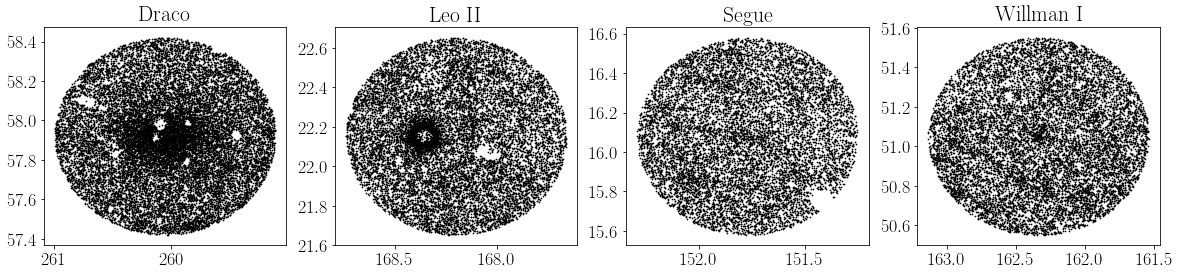

In [6]:
plt.figure(figsize = (20, 4))
k=0
for name in sdss_data:
    ra, dec = read_data('../data/sdss_fields/'+name)
    plt.subplot2grid((1,4), (0,k))
    plt.title(gal_name[k])
    
    plt.scatter(ra, dec, c = 'k', s = 0.5)
    plt.gca().invert_xaxis()
    
    k+=1

## Various Density Estimators - 

- Nearest Neighbor Density Estimator
- Kernel Density Estimator (Gaussian Kernels)
- Kernel Density Estimator (Top-Hat Kernels)
- Kernel Density Estimator (Exponential Kernels)
- Gaussian Mixture Model
- Two-point Correlation Funtion

In [7]:
## 

def overdensities(dens, sigma_min, sigma_max, xmin=0, xmax=1, ymin=0, ymax=1):
    # Defining grid
    x = np.linspace(xmin, xmax, np.shape(dens)[0])
    y = np.linspace(ymin, ymax, np.shape(dens)[1])
    X, Y = np.meshgrid(x, y)

    # Defining sigma as the standard deviation of the data
    sigma = np.std(dens.flatten())
    # Finding the median of the all the data in the field
    dens_median = np.median(dens.flatten())
    # Defining the contours range.·
    overdensities = []
    color_bar_labels = []

    for i in range(sigma_min, sigma_max+1):
        overdensities.append(dens_median + i*sigma)
        color_bar_labels.append(str(i) + '$\sigma$')
    #print(color_bar_labels)
    
    return X, Y, overdensities, color_bar_labels

## Nearest Neighbour Density Estimator 

/usr/local/lib/python3.5/dist-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


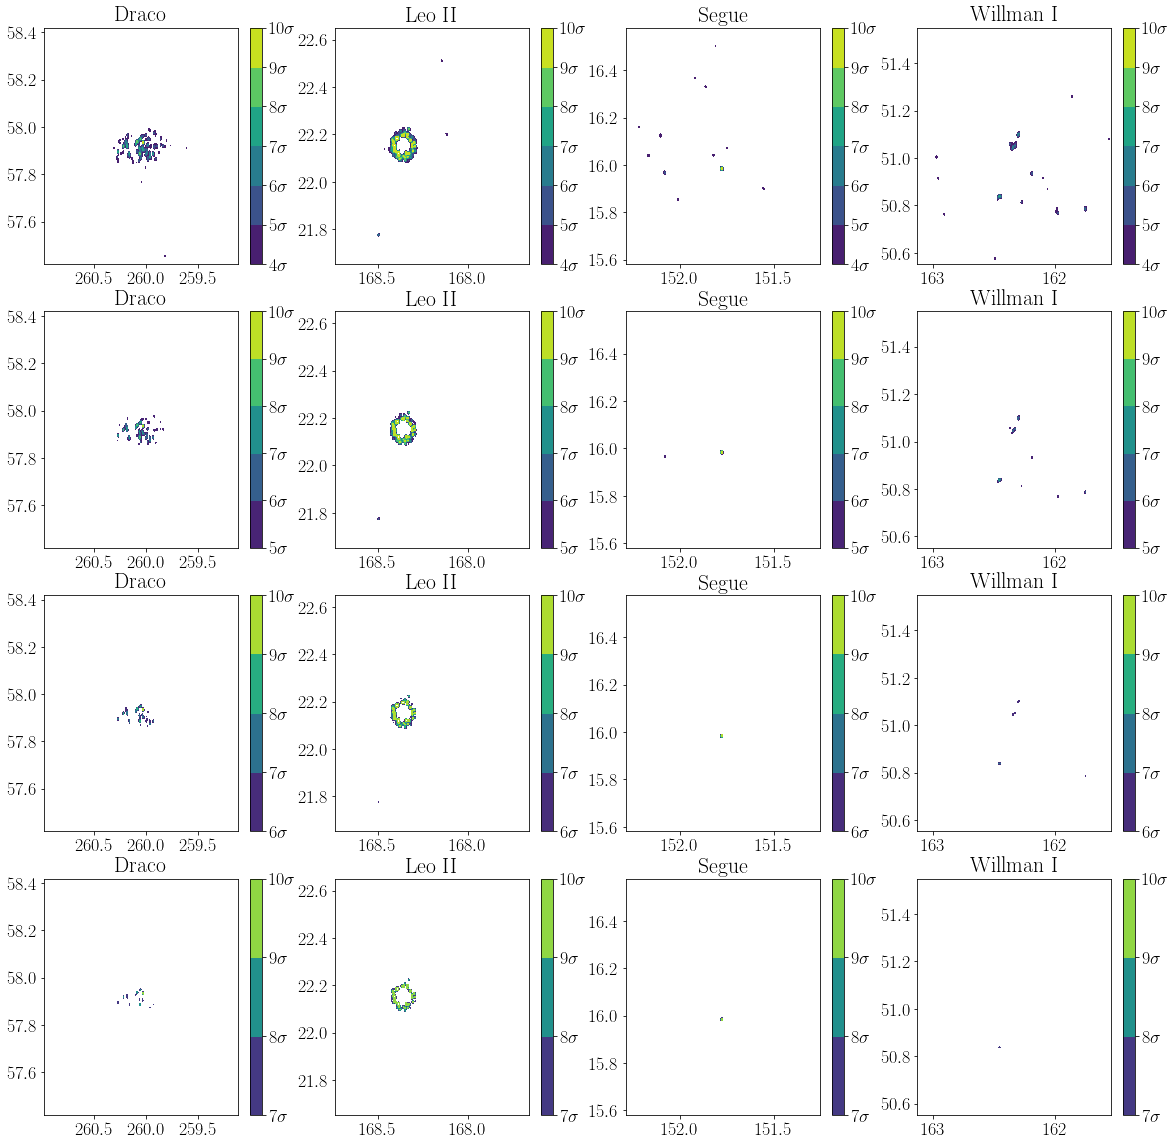

In [12]:
plt.figure(figsize = (20, 20))
k=0
for name in sdss_data:
    ra, dec = read_data('../data/sdss_fields/'+name)
    dens_field_NN = density_functions.NN_bayesian_density(ra, dec, 20, 500)
    
    X_NN_4, Y_NN_4, overdens_NN_4, colorbar_NN_4 = overdensities(dens_field_NN, 4, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))
    X_NN_5, Y_NN_5, overdens_NN_5, colorbar_NN_5 = overdensities(dens_field_NN, 5, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))
    X_NN_6, Y_NN_6, overdens_NN_6, colorbar_NN_6 = overdensities(dens_field_NN, 6, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))
    X_NN_7, Y_NN_7, overdens_NN_7, colorbar_NN_7 = overdensities(dens_field_NN, 7, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))

    plt.subplot2grid((4,4), (0, k))
    plt.title(gal_name[k])
    plt.contourf(X_NN_4, Y_NN_4, dens_field_NN, overdens_NN_4)
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_NN_4)+1, 1))
    cbar.ax.set_yticklabels(colorbar_NN_4)
    plt.gca().invert_xaxis()
    
    plt.subplot2grid((4,4), (1, k))
    plt.title(gal_name[k])
    plt.contourf(X_NN_5, Y_NN_5, dens_field_NN, overdens_NN_5)
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_NN_5)+1, 1))
    cbar.ax.set_yticklabels(colorbar_NN_5)
    plt.gca().invert_xaxis()
    
    plt.subplot2grid((4,4), (2, k))
    plt.title(gal_name[k])
    plt.contourf(X_NN_6, Y_NN_6, dens_field_NN, overdens_NN_6)
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_NN_6)+1, 1))
    cbar.ax.set_yticklabels(colorbar_NN_6)
    plt.gca().invert_xaxis()
    
    plt.subplot2grid((4,4), (3, k))
    plt.title(gal_name[k])
    plt.contourf(X_NN_7, Y_NN_7, dens_field_NN, overdens_NN_7)
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_NN_7)+1, 1))
    cbar.ax.set_yticklabels(colorbar_NN_7)
    plt.gca().invert_xaxis()
    
    k+=1
    

In [13]:
sigmas_NN = [6, 9, 4, 4]

## Kernel Density Estimator (Guassian Kernel)



/usr/local/lib/python3.5/dist-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


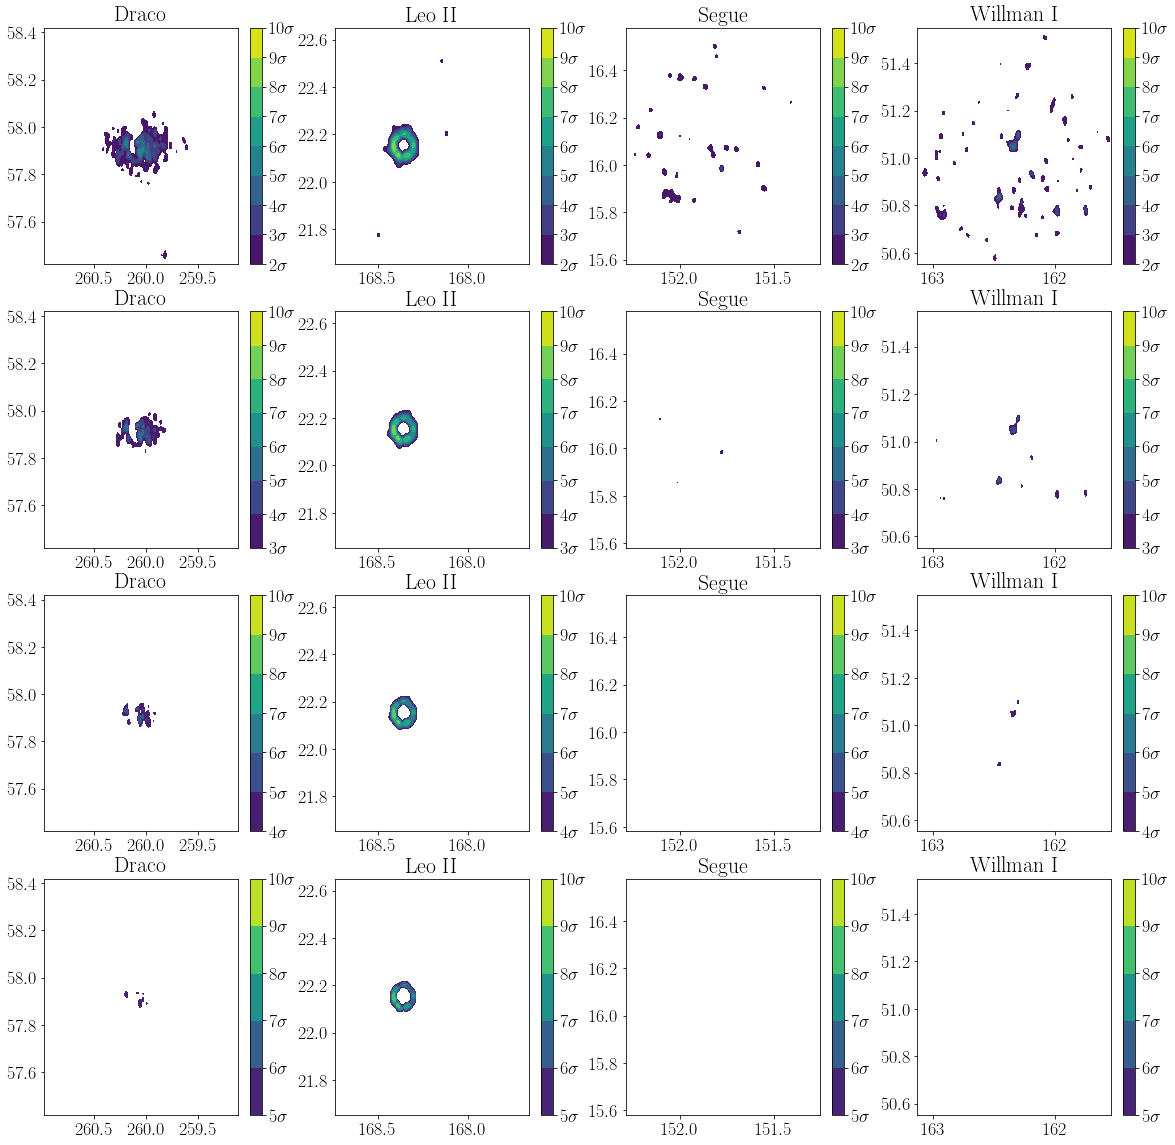

In [19]:
plt.figure(figsize = (20, 20))
k=0
for name in sdss_data:
    ra, dec = read_data('../data/sdss_fields/'+name)
    dens_field_KDE_gaussian = density_functions.KDE(ra,dec, kernel = 'gaussian')
   
    X_KDE_gaussian_4, Y_KDE_gaussian_4, overdens_KDE_gaussian_4, colorbar_KDE_gauss_4 = overdensities(dens_field_KDE_gaussian, 2, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    
    X_KDE_gaussian_5, Y_KDE_gaussian_5, overdens_KDE_gaussian_5, colorbar_KDE_gauss_5 = overdensities(dens_field_KDE_gaussian, 3, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    
    X_KDE_gaussian_6, Y_KDE_gaussian_6, overdens_KDE_gaussian_6, colorbar_KDE_gauss_6 = overdensities(dens_field_KDE_gaussian, 4, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    
    X_KDE_gaussian_7, Y_KDE_gaussian_7, overdens_KDE_gaussian_7, colorbar_KDE_gauss_7 = overdensities(dens_field_KDE_gaussian, 5, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    

    plt.subplot2grid((4,4), (0, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_gaussian_4, Y_KDE_gaussian_4, dens_field_KDE_gaussian, overdens_KDE_gaussian_4)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_gauss_4)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_gauss_4)
    
    plt.subplot2grid((4,4), (1, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_gaussian_5, Y_KDE_gaussian_5, dens_field_KDE_gaussian, overdens_KDE_gaussian_5)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_gauss_5)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_gauss_5)
    
    plt.subplot2grid((4,4), (2, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_gaussian_6, Y_KDE_gaussian_6, dens_field_KDE_gaussian, overdens_KDE_gaussian_6)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_gauss_6)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_gauss_6)
    
    plt.subplot2grid((4,4), (3, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_gaussian_7, Y_KDE_gaussian_7, dens_field_KDE_gaussian, overdens_KDE_gaussian_7)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_gauss_7)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_gauss_7)
        
    k+=1

## Kernel Density Estimator (Top-Hat Kernel)

/usr/local/lib/python3.5/dist-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


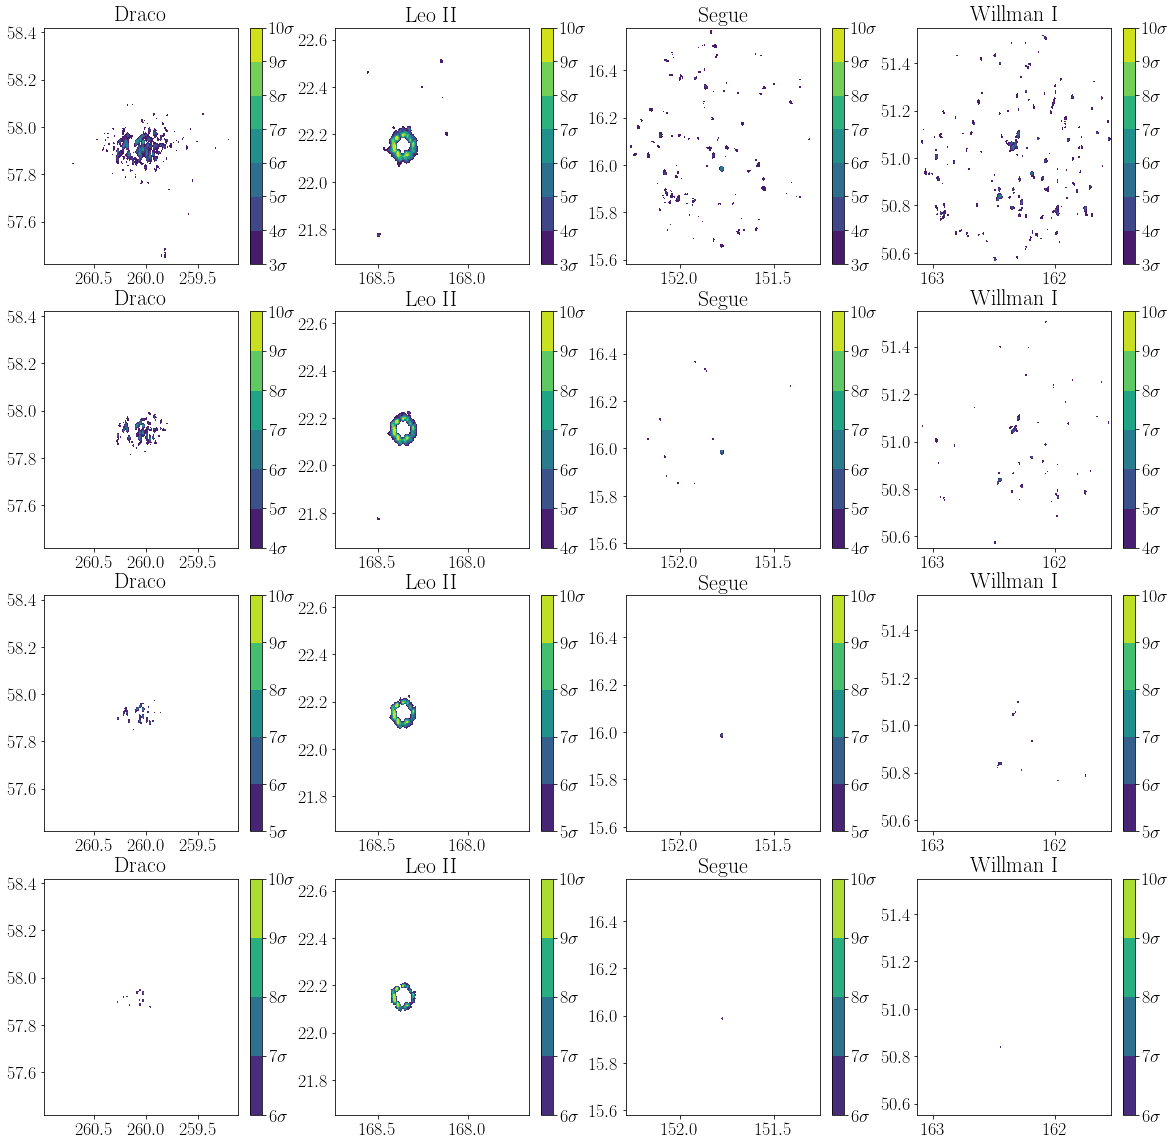

In [20]:
plt.figure(figsize = (20, 20))
k=0
for name in sdss_data:
    ra, dec = read_data('../data/sdss_fields/'+name)
    dens_field_KDE_th = density_functions.KDE(ra,dec, kernel = 'tophat') 
    
    X_KDE_th_4, Y_KDE_th_4, overdens_KDE_th_4, colorbar_KDE_th_4 = overdensities(dens_field_KDE_th, 3, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))
    X_KDE_th_5, Y_KDE_th_5, overdens_KDE_th_5, colorbar_KDE_th_5 = overdensities(dens_field_KDE_th, 4, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))
    X_KDE_th_6, Y_KDE_th_6, overdens_KDE_th_6, colorbar_KDE_th_6 = overdensities(dens_field_KDE_th, 5, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))
    X_KDE_th_7, Y_KDE_th_7, overdens_KDE_th_7, colorbar_KDE_th_7 = overdensities(dens_field_KDE_th, 6, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))

    plt.subplot2grid((4,4), (0, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_th_4, Y_KDE_th_4, dens_field_KDE_th, overdens_KDE_th_4)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_th_4)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_th_4)
    
    
    plt.subplot2grid((4,4), (1, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_th_5, Y_KDE_th_5, dens_field_KDE_th, overdens_KDE_th_5)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_th_5)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_th_5)
    
    
    plt.subplot2grid((4,4), (2, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_th_6, Y_KDE_th_6, dens_field_KDE_th, overdens_KDE_th_6)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_th_6)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_th_6)
    
    
    plt.subplot2grid((4,4), (3, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_th_7, Y_KDE_th_7, dens_field_KDE_th, overdens_KDE_th_7)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_th_7)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_th_7)
    
    
    
    k+=1

## Kernel Density Estimator (Exponential Kernels)

/usr/local/lib/python3.5/dist-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


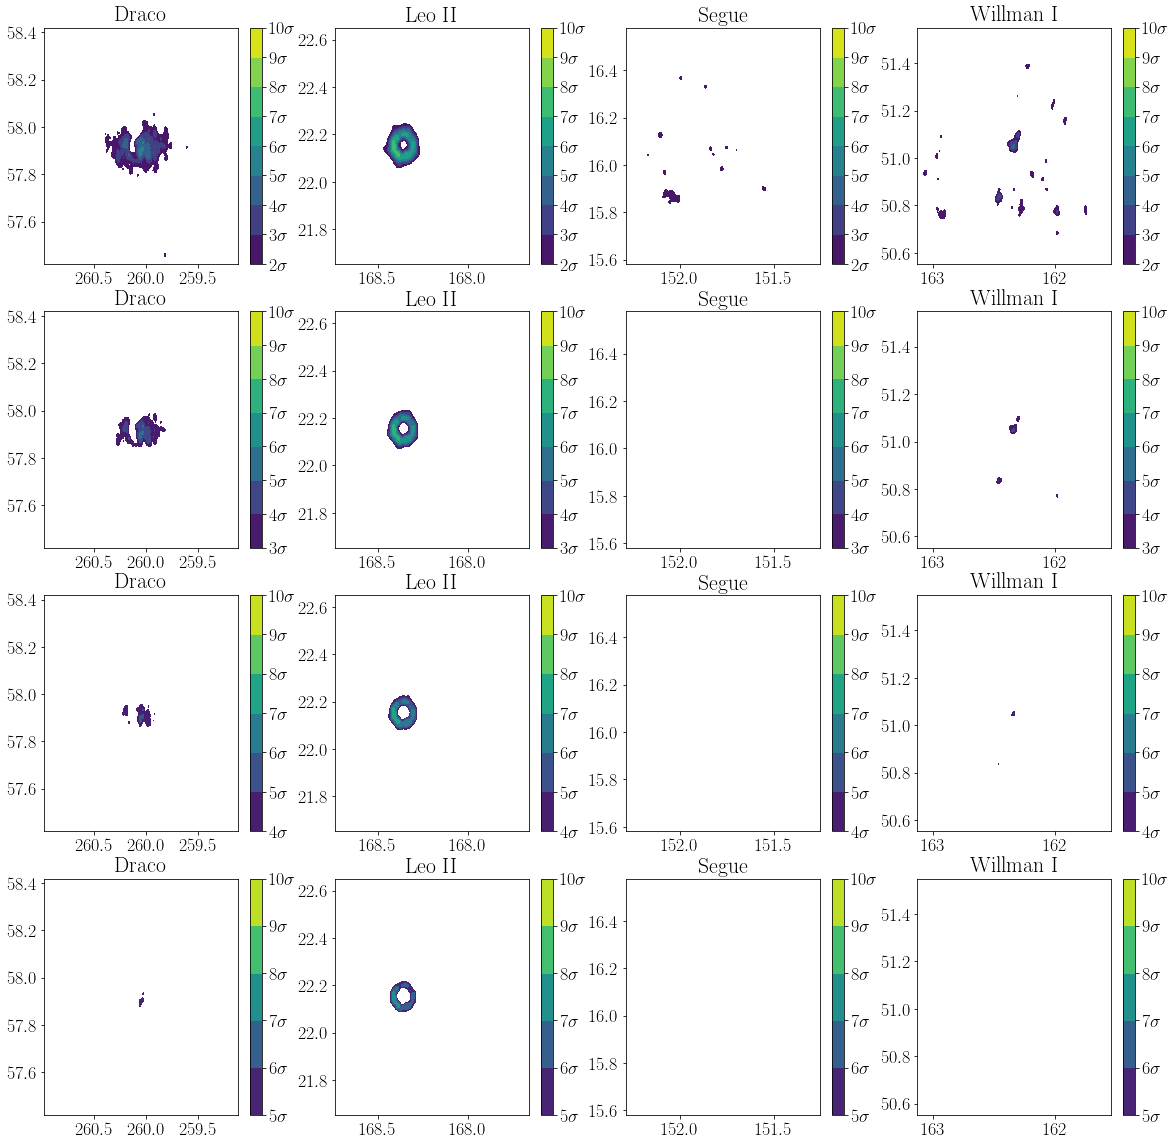

In [22]:
plt.figure(figsize = (20, 20))
k=0
for name in sdss_data:
    ra, dec = read_data('../data/sdss_fields/'+name)
    dens_field_KDE_exponential = density_functions.KDE(ra,dec, kernel = 'exponential')
    
    X_KDE_exp_4, Y_KDE_exp_4, overdens_KDE_exp_4, colorbar_KDE_exp_4 = overdensities(dens_field_KDE_exponential, 2, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    
    X_KDE_exp_5, Y_KDE_exp_5, overdens_KDE_exp_5, colorbar_KDE_exp_5 = overdensities(dens_field_KDE_exponential, 3, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    
    X_KDE_exp_6, Y_KDE_exp_6, overdens_KDE_exp_6, colorbar_KDE_exp_6 = overdensities(dens_field_KDE_exponential, 4, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    
    X_KDE_exp_7, Y_KDE_exp_7, overdens_KDE_exp_7, colorbar_KDE_exp_7 = overdensities(dens_field_KDE_exponential, 5, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    

    plt.subplot2grid((4,4), (0, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_exp_4, Y_KDE_exp_4, dens_field_KDE_exponential, overdens_KDE_exp_4)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_exp_4)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_exp_4)
    
    plt.subplot2grid((4,4), (1, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_exp_5, Y_KDE_exp_5, dens_field_KDE_exponential, overdens_KDE_exp_5)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_exp_5)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_exp_5)
    
    plt.subplot2grid((4,4), (2, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_exp_6, Y_KDE_exp_6, dens_field_KDE_exponential, overdens_KDE_exp_6)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_exp_6)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_exp_6)
    
    plt.subplot2grid((4,4), (3, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_exp_7, Y_KDE_exp_7, dens_field_KDE_exponential, overdens_KDE_exp_7)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_exp_7)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_exp_7)
    
    k+=1
    

In [24]:
sigmas_NN = [6, 9, 4, 4]
sigmas_KDE_gauss = [4, 7, 2, 3]
sigmas_KDE_th = [5, 8, 4, 4]
sigmas_KDE_exp = [4, 6, 2, 3]

## Conclusions

[Text(0,0,''),
 Text(0,0,'Draco'),
 Text(0,0,'Leo II'),
 Text(0,0,'Segue'),
 Text(0,0,'Willman I')]

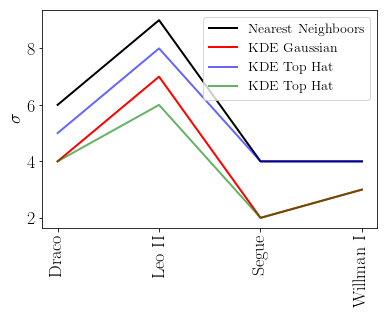

In [25]:
fig, ax = plt.subplots(1,1) 
ax.plot(np.arange(0, 4), sigmas_NN, c='k', label='Nearest Neighboors', lw=2)
ax.plot(np.arange(0, 4), sigmas_KDE_gauss, c='r',  label='KDE Gaussian', lw=2)
ax.plot(np.arange(0, 4), sigmas_KDE_th, c='b', alpha=0.6, label='KDE Top Hat', lw=2)
ax.plot(np.arange(0, 4), sigmas_KDE_exp, c='g', alpha=0.6, label='KDE Top Hat', lw=2)
ax.set_ylabel(r'$\sigma$')
ax.legend(fontsize=14)
x_ticks_labels = ['', 'Draco','Leo II','Segue','Willman I']
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=18)
